In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_curve, auc,
    mean_squared_error, ConfusionMatrixDisplay
)
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, SelectKBest, chi2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import warnings
import pickle

# Ignore all warnings
warnings.filterwarnings("ignore")

In [5]:
# Load the dataset
file_path = 'ObesityDataSet.csv'  # Update the path if necessary
data = pd.read_csv(file_path)


In [6]:
# Display dataset details
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  

In [7]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Missing Values in Each Column:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [8]:

# Label Encoding for Categorical Variables
label_encoders = {}
categorical_columns = data.select_dtypes(include=['object']).columns

print("\nCategorical Columns:", list(categorical_columns))


Categorical Columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [9]:
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    print(f"Encoded '{col}' with classes: {le.classes_}")

# Separate features (X) and target variable (y)
X = data.drop('NObeyesdad', axis=1)  # Assuming 'NObeyesdad' is the target variable
y = data['NObeyesdad']

Encoded 'Gender' with classes: ['Female' 'Male']
Encoded 'family_history_with_overweight' with classes: ['no' 'yes']
Encoded 'FAVC' with classes: ['no' 'yes']
Encoded 'CAEC' with classes: ['Always' 'Frequently' 'Sometimes' 'no']
Encoded 'SMOKE' with classes: ['no' 'yes']
Encoded 'SCC' with classes: ['no' 'yes']
Encoded 'CALC' with classes: ['Always' 'Frequently' 'Sometimes' 'no']
Encoded 'MTRANS' with classes: ['Automobile' 'Bike' 'Motorbike' 'Public_Transportation' 'Walking']
Encoded 'NObeyesdad' with classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [10]:
# --- Feature Selection ---

# 1. Mutual Information
mi_scores = mutual_info_classif(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores}).sort_values(by='MI Score', ascending=False)
print("\nMutual Information Scores:")
print(mi_scores_df)


Mutual Information Scores:
                           Feature  MI Score
3                           Weight  1.247145
1                              Age  0.598636
2                           Height  0.421581
6                             FCVC  0.403491
10                            CH2O  0.318551
12                             FAF  0.309799
13                             TUE  0.272633
7                              NCP  0.242619
0                           Gender  0.194847
4   family_history_with_overweight  0.181790
8                             CAEC  0.162684
15                          MTRANS  0.088358
14                            CALC  0.087582
5                             FAVC  0.061733
9                            SMOKE  0.028737
11                             SCC  0.015973


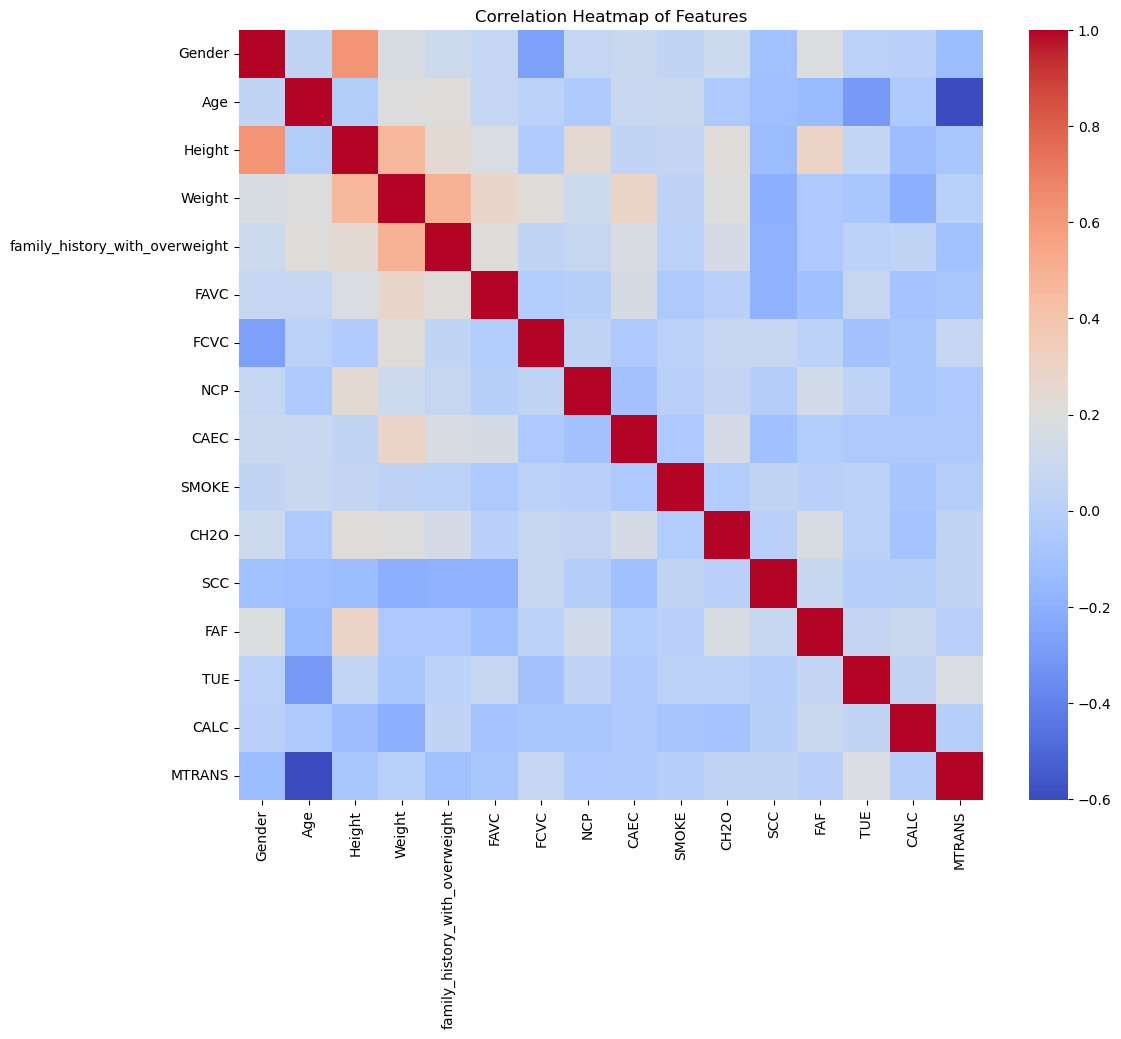

In [11]:
# 3. Correlation Analysis
correlation_matrix = pd.DataFrame(X).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Features")
plt.show()

In [12]:
# Remove features based on domain knowledge or high correlation
# (e.g., drop highly correlated features or less relevant features)
features_to_drop = ['SMOKE', 'SCC','FAF', 'MTRANS','FAVC','CALC','family_history_with_overweight','CAEC','Gender','NCP','TUE','CH2O']  # Example: Update based on analysis
X_reduced = X.drop(columns=features_to_drop)

print("\nReduced Feature Set After Feature Selection:", list(X_reduced.columns))



Reduced Feature Set After Feature Selection: ['Age', 'Height', 'Weight', 'FCVC']


In [13]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [14]:
# --- Gaussian Process Classification (GPC) ---
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel()

# Train the Gaussian Process Classifier
gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
gpc.fit(X_train, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          random_state=42)

In [15]:
# Predictions and Evaluation
y_pred_gpc = gpc.predict(X_test)

# Accuracy
accuracy_gpc = accuracy_score(y_test, y_pred_gpc)
print(f"\nAccuracy (Gaussian Process Classifier): {accuracy_gpc:.2f}")


Accuracy (Gaussian Process Classifier): 0.96


In [16]:
# Classification Report
print("\nClassification Report (Gaussian Process Classifier):")
print(classification_report(y_test, y_pred_gpc))



Classification Report (Gaussian Process Classifier):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        56
           1       0.95      0.85      0.90        62
           2       0.99      1.00      0.99        78
           3       1.00      0.98      0.99        58
           4       1.00      1.00      1.00        63
           5       0.90      0.93      0.91        56
           6       0.94      0.98      0.96        50

    accuracy                           0.96       423
   macro avg       0.96      0.96      0.96       423
weighted avg       0.96      0.96      0.96       423



In [17]:
# Perform cross-validation on the Gaussian Process Classifier
# Use X_reduced for cross-validation
cv_scores_gpc = cross_val_score(gpc, X_reduced, y, cv=3, scoring='accuracy', n_jobs=-1)

# Display cross-validation results
print("\nCross-Validation Scores (Gaussian Process Classifier):", cv_scores_gpc)
print("Mean Cross-Validation Score (Gaussian Process Classifier): {:.2f}".format(cv_scores_gpc.mean()))


Cross-Validation Scores (Gaussian Process Classifier): [0.8125     0.81960227 0.81507824]
Mean Cross-Validation Score (Gaussian Process Classifier): 0.82


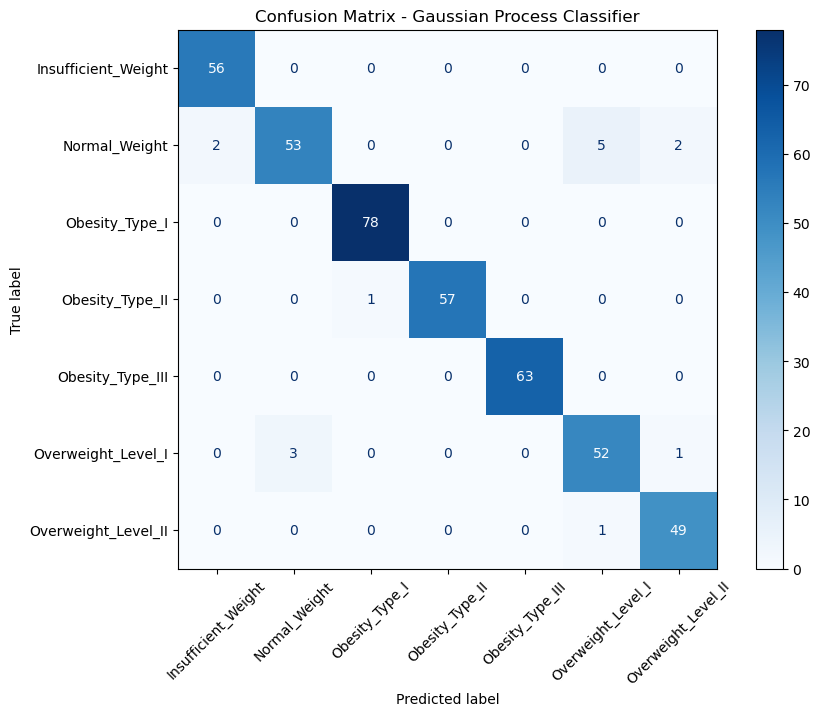

In [25]:
# Generate predictions on the test set
y_pred_gpc = gpc.predict(X_test)

# Compute the confusion matrix
conf_matrix_gpc = confusion_matrix(y_test, y_pred_gpc)

# Retrieve class labels from the LabelEncoder
class_labels = label_encoders['NObeyesdad'].classes_  # Original class names

# Create the confusion matrix display with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gpc, display_labels=class_labels)

# Plot with adjusted figure size and rotated x-axis labels
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust figure size
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)  # Rotate x-axis labels

plt.title("Confusion Matrix - Gaussian Process Classifier")
plt.show()


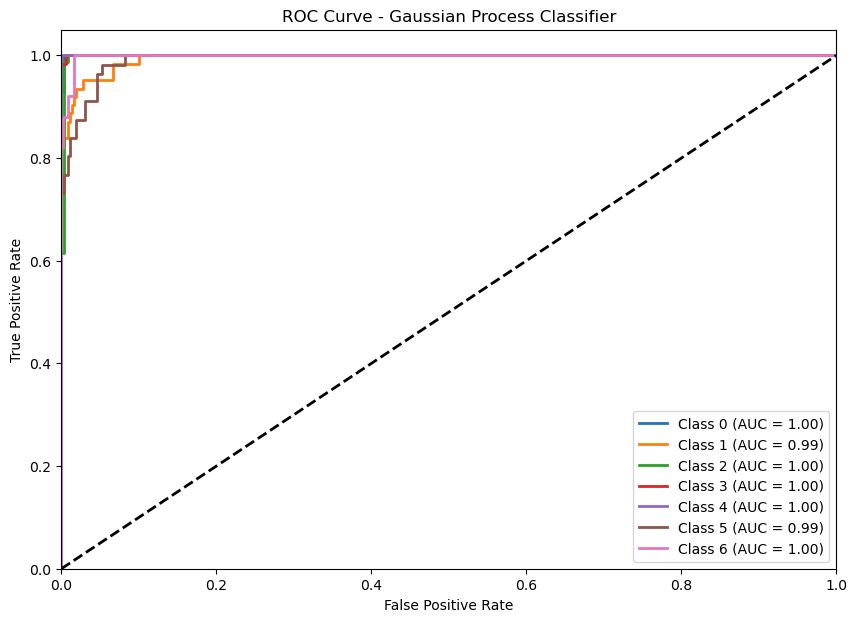

In [29]:
# Binarize the target variable for multi-class ROC computation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Predict probabilities for the test set
y_score_gpc = gpc.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_gpc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Process Classifier')
plt.legend(loc="lower right")
plt.show()


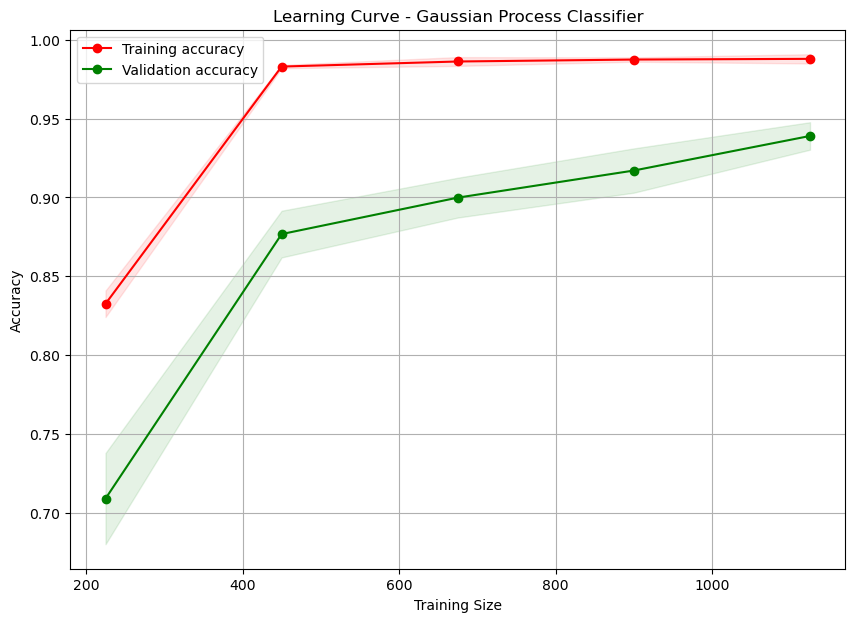

In [30]:
# Use a subset of the data for faster computation
X_subset, _, y_subset, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Generate the learning curve with reduced settings
train_sizes, train_scores, test_scores = learning_curve(
    gpc, X_subset, y_subset, cv=3, scoring='accuracy', train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation accuracy")
plt.title("Learning Curve - Gaussian Process Classifier")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [38]:
# Refit the encoder with all unique labels
label_encoders['NObeyesdad'].fit(y)
y_regression = label_encoders['NObeyesdad'].transform(y)


In [40]:
# --- Gaussian Process Regression (GPR) ---
# Convert target to numeric values for regression
y_regression = label_encoders['NObeyesdad'].transform(y)

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_scaled, y_regression, test_size=0.35, random_state=42)

# Define kernel for GPR
kernel_reg = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))



In [42]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor

# Define different kernels
rbf_kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
matern_kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5)
rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)
linear_kernel = DotProduct()
white_kernel = WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e+1))

# Composite kernels
composite_kernel = RBF() + WhiteKernel()


In [44]:
# Define a list of kernels
kernels = [
    RBF(),
    Matern(nu=1.5),
    RationalQuadratic(),
    DotProduct(),
    RBF() + WhiteKernel(),
    Matern() + WhiteKernel()
]

# Iterate over kernels
for kernel in kernels:
    print(f"Training Gaussian Process Classifier with kernel: {kernel}")
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=42)
    gpc.fit(X_train, y_train)
    
    # Evaluate performance
    accuracy = gpc.score(X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}\n")


Training Gaussian Process Classifier with kernel: RBF(length_scale=1)
Accuracy: 0.82

Training Gaussian Process Classifier with kernel: Matern(length_scale=1, nu=1.5)
Accuracy: 0.84

Training Gaussian Process Classifier with kernel: RationalQuadratic(alpha=1, length_scale=1)
Accuracy: 0.87

Training Gaussian Process Classifier with kernel: DotProduct(sigma_0=1)
Accuracy: 0.44

Training Gaussian Process Classifier with kernel: RBF(length_scale=1) + WhiteKernel(noise_level=1)
Accuracy: 0.82

Training Gaussian Process Classifier with kernel: Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)
Accuracy: 0.84



In [45]:
# Define the RationalQuadratic kernel
kernel_rational_quadratic = RationalQuadratic(alpha=1.0, length_scale=1.0)

# Train the Gaussian Process Regressor with RationalQuadratic kernel
gpr = GaussianProcessRegressor(kernel=kernel_rational_quadratic, random_state=42)
gpr.fit(X_train_reg, y_train_reg)

# Check the kernel used after training
print("Kernel used in Gaussian Process Regressor:")
print(gpr.kernel_)

# Predictions and Evaluation
y_pred_gpr = gpr.predict(X_test_reg)

Kernel used in Gaussian Process Regressor:
RationalQuadratic(alpha=0.318, length_scale=0.0563)


In [46]:
# Predictions and Evaluation
y_pred_gpr = gpr.predict(X_test_reg)

# Calculate regression metrics

mse_gpr = mean_squared_error(y_test_reg, y_pred_gpr)
rmse_gpr = np.sqrt(mse_gpr)
r2_gpr = r2_score(y_test_reg, y_pred_gpr)

# Print regression metrics

print(f"Mean Squared Error (MSE): {mse_gpr:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gpr:.2f}")
print(f"R-squared (R²): {r2_gpr:.2f}")


Mean Squared Error (MSE): 0.78
Root Mean Squared Error (RMSE): 0.89
R-squared (R²): 0.79


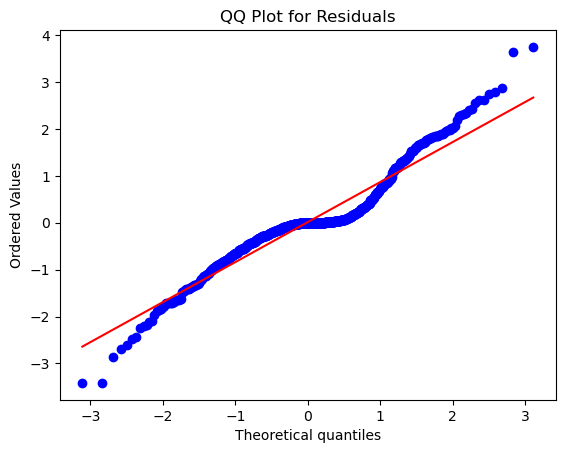

In [47]:
# Calculate residuals
residuals = y_test_reg - y_pred_gpr
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot for Residuals")
plt.show()


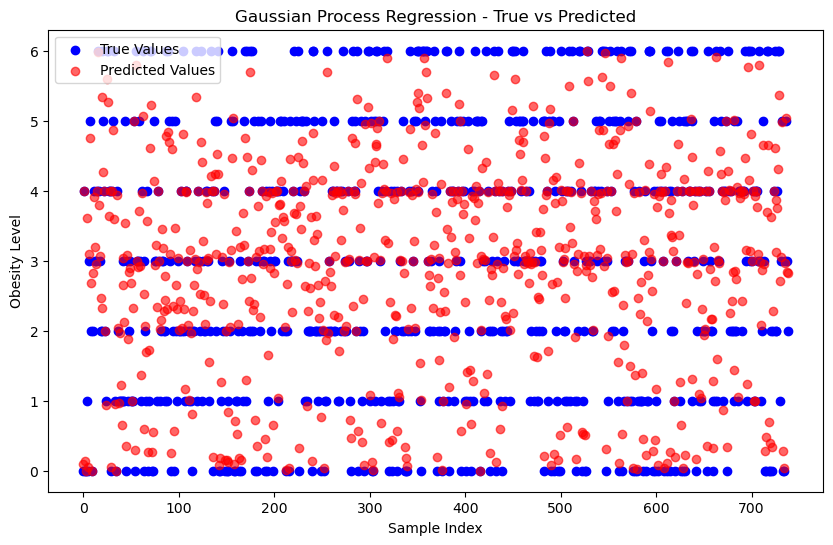

In [48]:
# Plotting True vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_reg)), y_test_reg, color='blue', label='True Values')
plt.scatter(range(len(y_pred_gpr)), y_pred_gpr, color='red', label='Predicted Values', alpha=0.6)
plt.title("Gaussian Process Regression - True vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Obesity Level")
plt.legend()
plt.show()

In [50]:
# Clamp function to restrict predictions to the valid range
def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

# Mapping numerical values to categorical labels
nobeyesdad_categories = {
    0: "Insufficient_Weight",
    1: "Normal_Weight",
    2: "Overweight_Level_I",
    3: "Overweight_Level_II",
    4: "Obesity_Type_I",
    5: "Obesity_Type_II",
    6: "Obesity_Type_III"
}

# Manually input feature values
input_features = {
    "Age": float(input("Enter Age: ")),
    "Height": float(input("Enter Height (in cm): ")),
    "Weight": float(input("Enter Weight (in kg): ")),
    "FCVC": int(input("Enter FCVC (Frequency of Vegetable Consumption, 1-3): "))
}

# Prepare the input feature vector
input_vector = np.array([
    input_features["Age"],
    input_features["Height"],
    input_features["Weight"],
    input_features["FCVC"]
]).reshape(1, -1)

# Scale the input vector
input_vector_scaled = scaler.transform(input_vector)

# Predict the target (NObeyesdad) using the trained Gaussian Process Regressor
predicted_nobeyesdad_numerical = gpr.predict(input_vector_scaled)[0]

# Clamp the prediction to the valid range (0–6)
predicted_nobeyesdad_clamped = clamp(predicted_nobeyesdad_numerical, 0, 6)

# Map the clamped prediction back to the categorical label
predicted_nobeyesdad_index = int(round(predicted_nobeyesdad_clamped))
predicted_nobeyesdad_categorical = nobeyesdad_categories.get(predicted_nobeyesdad_index, "Unknown Category")

# Print the predictions
# print(f"\nPredicted NObeyesdad (Numerical): {predicted_nobeyesdad_numerical:.2f}")
print(f"Predicted NObeyesdad: {predicted_nobeyesdad_clamped:.2f}")
print(f"Predicted NObeyesdad (Categorical): {predicted_nobeyesdad_categorical}")


Enter Age:  23
Enter Height (in cm):  170
Enter Weight (in kg):  40
Enter FCVC (Frequency of Vegetable Consumption, 1-3):  2


Predicted NObeyesdad: 0.00
Predicted NObeyesdad (Categorical): Insufficient_Weight


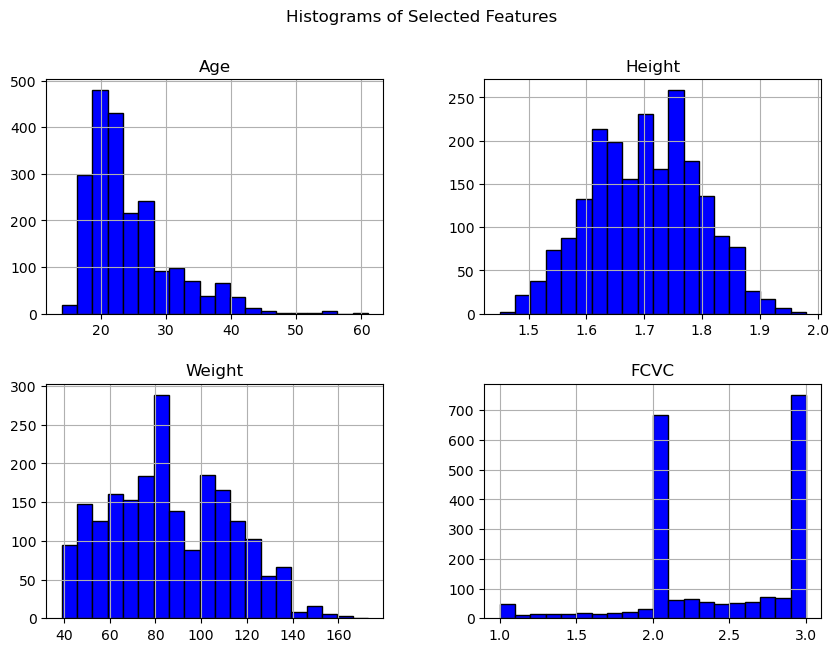

In [51]:
# Select specific features to plot histograms
features_to_plot = ['Age', 'Height', 'Weight','FCVC']  # Example features
X_subset_df = X_reduced[features_to_plot]

# Plot histograms for the selected features
X_subset_df.hist(bins=20, figsize=(10, 7), color='blue', edgecolor='black')
plt.suptitle('Histograms of Selected Features')
plt.show()


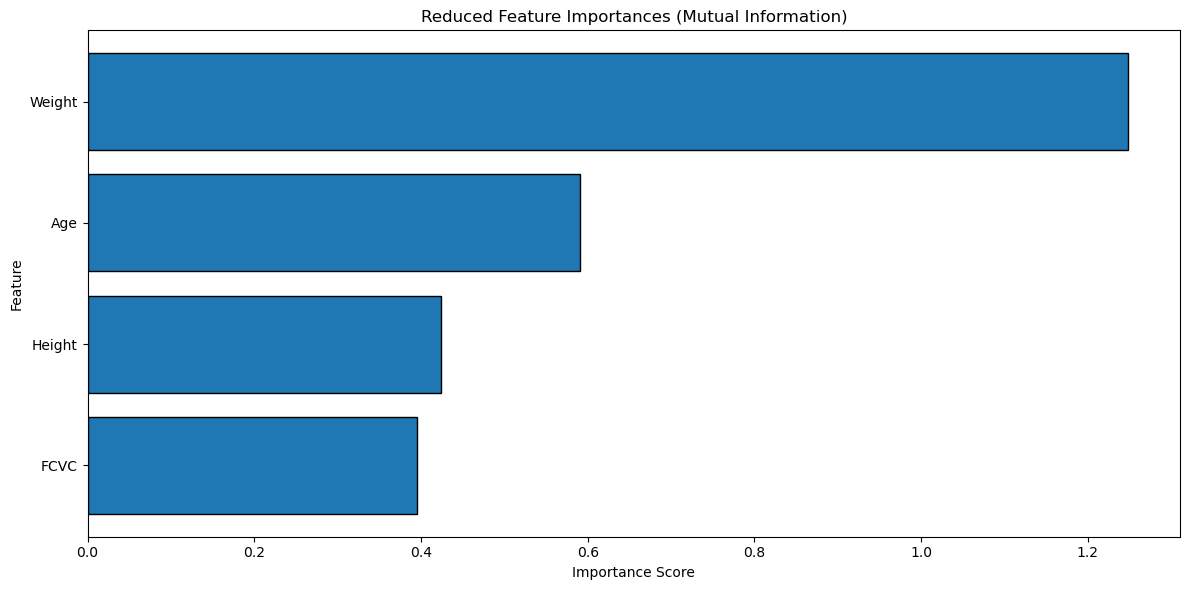

In [52]:
# Calculate mutual information scores as a proxy for feature importance
mi_scores = mutual_info_classif(X_reduced, y)

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': mi_scores
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.title("Reduced Feature Importances (Mutual Information)")

# Bar chart for mutual information scores
plt.barh(
    feature_importance_df['Feature'], 
    feature_importance_df['Importance'], 
    align='center', 
    color='#1f77b4', 
    edgecolor='black'
)

plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()

In [53]:
# Assuming X_reduced is the reduced feature set and y is the target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)  # Fit on training features only


# Save both the GPC model and the scaler
with open('gaussian_process_models.pickle', 'wb') as f:
    pickle.dump({
        'classifier_model': gpc,  # Gaussian Process Classifier
        'scaler': scaler          # StandardScaler used for feature scaling
    }, f)

print("Gaussian Process models and scaler have been saved successfully!")


Gaussian Process models and scaler have been saved successfully!
